# Exploratory Analysis - DC Moving Violations, 2015-2020

This notebook looks at fine payments, moving violation counts and moving violation types across wards.

### Import Libraries

In [2]:
##Import Libraries
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pandas.io.sql as psql
import geopandas as gpd
import SQL_cred
from collections import Counter

### Create Ward Population Data Frame

In [3]:
#Info Pulled From https://www.dchealthmatters.org/demographicdata
dc_ward_pop=pd.DataFrame({'Population':[91673,92809,84979,87150,90380,103197,80669,80517],'ward_name':['Ward 1','Ward 2','Ward 3','Ward 4','Ward 5','Ward 6','Ward 7','Ward 8']})
dc_ward_pop

,Population,ward_name
0,91673,Ward 1
1,92809,Ward 2
2,84979,Ward 3
3,87150,Ward 4
4,90380,Ward 5
5,103197,Ward 6
6,80669,Ward 7
7,80517,Ward 8


## Fine Payment

### Load Data, Basic Handling

In [4]:
#Set SQL Address, Create SQL import function 'load_data'
conn_string = "host="+ SQL_cred.PGHOST +" port="+ "5432" +" dbname="+ SQL_cred.PGDATABASE +" user=" + SQL_cred.PGUSER \
+" password="+ SQL_cred.PGPASSWORD

def load_data(query):

    sql_command = query
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print(data.shape)
    return (data)

In [5]:
#Select all fine information from 2015 to 2020
#conn=psycopg2.connect(conn_string)
#query="SELECT fine_amount,total_paid, ward_name FROM analysis_data.moving_violations WHERE EXTRACT (year FROM issue_date) BETWEEN 2015 AND 2020;"
#cursor = conn.cursor()
#df=load_data(query)
#df.to_csv('Fines.csv')

In [5]:
df=pd.read_csv('Fines.csv',index_col=0)

C:\Users\amcas\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [61]:
df.fine_amount.fillna(0,inplace=True)
df.total_paid.fillna(0,inplace=True)
df.ward_name.fillna('Unknown',inplace=True)

pd.set_option('display.max_rows', None)
df.head(10)

In [62]:
#Set Categories for fines & how they were paid
FvP=[]
for fine,paid in list(zip(df.fine_amount,df.total_paid)):
    if fine==0 and paid==0:
        FvP.append('No Fine')
    elif fine==paid:
        FvP.append('Fined & Paid Full')
    elif fine>0 and paid==0:
        FvP.append('Fined & Paid Nothing')
    elif fine>0 and fine>paid:
        FvP.append('Fined & Paid Less')
    elif fine>0 and fine<paid:
        FvP.append('Fined & Paid More')
    else:
        FvP.append('Na')
df['Fined_v_Paid']=FvP

### How fines were handled for violations in all of DC, 2015-2020

In [63]:
df_fines_alldc=pd.concat([df['Fined_v_Paid'].value_counts(),(df['Fined_v_Paid'].value_counts()/df['Fined_v_Paid'].value_counts().sum())*100],axis=1)
df_fines_alldc.columns=['Count','Percentage']
df_fines_alldc

,Count,Percentage
Fined & Paid Full,1915450,52.400658
Fined & Paid Nothing,1416032,38.738160
Fined & Paid More,295057,8.071827
Fined & Paid Less,27529,0.753106
No Fine,1307,0.035755
Na,18,0.000492


In [64]:
#Group fine counts by ward and fine type
df_grouped_fine=df.groupby(['ward_name','Fined_v_Paid']).count().reset_index(level=[0,1])
df_fine_count=df_grouped_fine.pivot(index='ward_name',columns=['Fined_v_Paid'],values='fine_amount').drop(columns='Na')

In [65]:
#Create a data frame with fine percentages by ward
df_fine_pct=df_fine_count.apply((lambda x: x/x.sum()),axis=1)
df_fine_count['Total']=df_fine_count.sum(axis=1)

### Counts of how fines were handled for traffic incidents by ward, sorted by total, 2015-2020

In [66]:
df_fine_count.sort_values('Total',ascending=False)

Fined_v_Paid,Fined & Paid Full,Fined & Paid Less,Fined & Paid More,Fined & Paid Nothing,No Fine,Total
ward_name,,,,,,
Ward 7,329051,4623,59529,411342,80,804625
Ward 8,378806,9238,50119,308012,100,746275
Ward 5,380989,4038,59379,273164,108,717678
Ward 2,240866,2942,29064,105912,124,378908
Ward 4,176689,2033,28553,100352,630,308257
Ward 6,148012,2277,30300,105250,121,285960
Ward 3,195847,1383,24730,62495,21,284476
Ward 1,62145,928,12080,43920,73,119146
Unknown,3045,67,1303,5585,50,10050


### Percentages of how fines were handled for traffic incidents by ward, sorted by Paid Nothing, 2015-2020

In [71]:
#df_fine_pct=df_fine_pct*100
df_fine_pct.sort_values('Fined & Paid Nothing', ascending=False)

Fined_v_Paid,Fined & Paid Full,Fined & Paid Less,Fined & Paid More,Fined & Paid Nothing,No Fine
ward_name,,,,,
Unknown,30.298507,0.666667,12.965174,55.572139,0.497512
Ward 7,40.894951,0.574553,7.398353,51.122200,0.009943
Ward 8,50.759573,1.237881,6.715889,41.273257,0.013400
Ward 5,53.086342,0.562648,8.273766,38.062195,0.015049
Ward 1,52.158696,0.778876,10.138821,36.862337,0.061269
Ward 6,51.759687,0.796265,10.595888,36.805847,0.042314
Ward 4,57.318731,0.659515,9.262726,32.554654,0.204375
Ward 2,63.568465,0.776442,7.670464,27.951904,0.032726
Ward 3,68.844823,0.486157,8.693176,21.968461,0.007382


#  Violation Count & Types by Ward

## Violation Counts by Ward

### Load Traffic Data

In [13]:
#Query database, save csv to local files
#Select all violation descriptons from 2015 to 2020 along with road type & ward name
#conn=psycopg2.connect(conn_string)
#query="SELECT ward_name, violation_process_desc, dcfunctionalclass_desc FROM analysis_data.moving_violations WHERE EXTRACT (year FROM issue_date) BETWEEN 2015 AND 2020;"
#cursor = conn.cursor()
#df_violations=load_data(query)
#df_violations.rename(columns={"violation_process_desc":"Violations"},inplace=True)
#df_violations.to_csv('Violations_by_Ward_2015_2020')

In [14]:
#Read in local csv data
df_violations=pd.read_csv('Violations_by_Ward_2015_2020.csv',usecols=[1,2,3])
df_violations.head()

,ward_name,Violations,dcfunctionalclass_desc
0,Ward 7,SPEED 11-15 MPH OVER THE SPEED LIMIT,NaN
1,Ward 7,OWNER OPERATE OR PERMIT OPERATION OF UNINSRD VEH,NaN
2,Ward 7,FAIL TO PAY ATTENTION WHILE OPERATING A VEHICLE,NaN
3,Ward 7,MAKING A TURN FROM THE WRONG LANE,Principal Arterial
4,Ward 7,FAIL TO KEEP IN LANE,NaN


### Load Map 

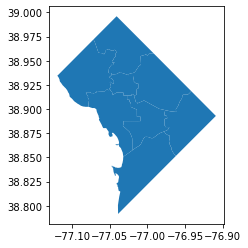

In [15]:
#https://opendata.dc.gov/datasets/0ef47379cbae44e88267c01eaec2ff6e_31?geometry=-77.668%2C38.800%2C-76.361%2C38.987
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
b='DC_Ward_Map/Ward_from_2012.shp'
map_df=gpd.read_file(b)
map_df=map_df.sort_values('WARD_ID')
map_df.plot()
plt.show()

### Get total violation counts per ward, per capita

In [16]:
ViolationsByward=df_violations.groupby('ward_name').count()
ViolationsByward.reset_index(inplace=True)
ViolationsByward

,ward_name,Violations,dcfunctionalclass_desc
0,Ward 1,119146,18314
1,Ward 2,378911,342217
2,Ward 3,284477,13607
3,Ward 4,308258,287471
4,Ward 5,717681,180586
5,Ward 6,285960,210330
6,Ward 7,804628,458761
7,Ward 8,746276,170644


In [17]:
ViolationsBywardPop=ViolationsByward.merge(dc_ward_pop)
ViolationsBywardPop['TotalViolationsPerCap']=ViolationsBywardPop.Violations/ViolationsBywardPop.Population
ViolationsBywardPop=ViolationsBywardPop.sort_values('TotalViolationsPerCap',ascending=False).drop(columns='dcfunctionalclass_desc')

In [18]:
ViolationsBywardPop

,ward_name,Violations,Population,TotalViolationsPerCap
6,Ward 7,804628,80669,9.974439
7,Ward 8,746276,80517,9.268552
4,Ward 5,717681,90380,7.940706
1,Ward 2,378911,92809,4.082697
3,Ward 4,308258,87150,3.537097
2,Ward 3,284477,84979,3.347615
5,Ward 6,285960,103197,2.771011
0,Ward 1,119146,91673,1.299685


In [19]:
map_df=map_df.merge(ViolationsBywardPop[['ward_name','TotalViolationsPerCap']],left_on='NAME',right_on='ward_name')

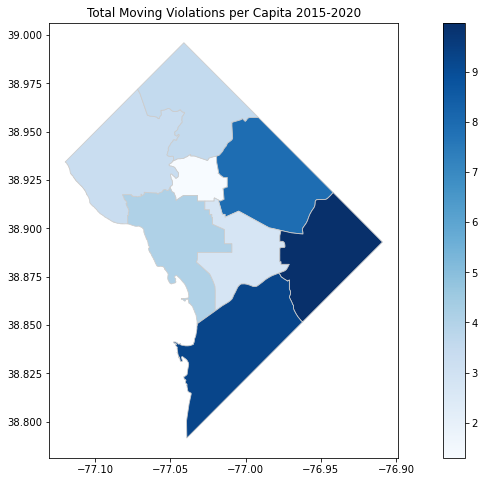

In [46]:
variable = "TotalViolationsPerCap"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Total Moving Violations per Capita 2015-2020')
plt.show()

In [21]:
ViolationsBywardPop

,ward_name,Violations,Population,TotalViolationsPerCap
6,Ward 7,804628,80669,9.974439
7,Ward 8,746276,80517,9.268552
4,Ward 5,717681,90380,7.940706
1,Ward 2,378911,92809,4.082697
3,Ward 4,308258,87150,3.537097
2,Ward 3,284477,84979,3.347615
5,Ward 6,285960,103197,2.771011
0,Ward 1,119146,91673,1.299685


##### Ward 5, 7 & 8 have the highest per capita violations - Ward 7 & 8 have at least 2.5x greater than Wards 4, 3, 6 & 1. 


##### But wards 5, 7 & 8 also have the most highways - presumably . Can the data be normalized by which types of roads they occur on?


### Determining the road type where violations occur most

In [22]:
#Fill unknown road types with 'Unknown'
df_violations['dcfunctionalclass_desc']=df_violations['dcfunctionalclass_desc'].fillna('Unknown')
df_violations.head(5)

,ward_name,Violations,dcfunctionalclass_desc
0,Ward 7,SPEED 11-15 MPH OVER THE SPEED LIMIT,Unknown
1,Ward 7,OWNER OPERATE OR PERMIT OPERATION OF UNINSRD VEH,Unknown
2,Ward 7,FAIL TO PAY ATTENTION WHILE OPERATING A VEHICLE,Unknown
3,Ward 7,MAKING A TURN FROM THE WRONG LANE,Principal Arterial
4,Ward 7,FAIL TO KEEP IN LANE,Unknown


In [23]:
#Group by ward & road type
ViolationsByRoadtype=df_violations.groupby(['ward_name','dcfunctionalclass_desc']).count()
ViolationsByRoadtype.reset_index(inplace=True)
ViolationsByRoadtype.head(5)

,ward_name,dcfunctionalclass_desc,Violations
0,Ward 1,Collector,7142
1,Ward 1,Local,2111
2,Ward 1,Minor Arterial,1442
3,Ward 1,Principal Arterial,7618
4,Ward 1,Unknown,100833


##### Looks like a lot of road types are unknown for these violations. Is this systematic across wards?

In [30]:
#Look at just the unknown road types
ViolationsUnknownLocationType=ViolationsByRoadtype.loc[ViolationsByRoadtype['dcfunctionalclass_desc']=='Unknown']
ViolationsUnknownLocationType=ViolationsUnknownLocationType.merge(ViolationsBywardPop,on='ward_name',suffixes=['_Unkn','_Tot'])
ViolationsUnknownLocationType
#ViolationsByward2_['NormalizedViolations']=ViolationsByward2.Violations/ViolationsByward2.Population
#ViolationsByward2_.sort_values('NormalizedViolations',ascending=False).drop(columns='dcfunctionalclass_desc')

,ward_name,dcfunctionalclass_desc,Violations_Unkn,Violations_Tot,Population,TotalViolationsPerCap
0,Ward 1,Unknown,100833,119146,91673,1.299685
1,Ward 2,Unknown,36695,378911,92809,4.082697
2,Ward 3,Unknown,270870,284477,84979,3.347615
3,Ward 4,Unknown,20787,308258,87150,3.537097
4,Ward 5,Unknown,537095,717681,90380,7.940706
5,Ward 6,Unknown,75631,285960,103197,2.771011
6,Ward 7,Unknown,345867,804628,80669,9.974439
7,Ward 8,Unknown,575632,746276,80517,9.268552


In [31]:
ViolationsUnknownLocationType['Unknown_by_ward']=ViolationsUnknownLocationType.Violations_Unkn/ViolationsUnknownLocationType.Violations_Tot
ViolationsUnknownLocationType.sort_values('Unknown_by_ward',ascending=False)

,ward_name,dcfunctionalclass_desc,Violations_Unkn,Violations_Tot,Population,TotalViolationsPerCap,Unknown_by_ward
2,Ward 3,Unknown,270870,284477,84979,3.347615,0.952168
0,Ward 1,Unknown,100833,119146,91673,1.299685,0.846298
7,Ward 8,Unknown,575632,746276,80517,9.268552,0.771339
4,Ward 5,Unknown,537095,717681,90380,7.940706,0.748376
6,Ward 7,Unknown,345867,804628,80669,9.974439,0.429847
5,Ward 6,Unknown,75631,285960,103197,2.771011,0.264481
1,Ward 2,Unknown,36695,378911,92809,4.082697,0.096843
3,Ward 4,Unknown,20787,308258,87150,3.537097,0.067434


##### Unfortunately, the number of Unknown road types is extremely spread out across wards - accounting for 95% of incidents for ward 3 and just 6 % for ward 4, with all the other roads scattered in between. We'll need to fill in more of these data points to normalize by this value.
##### Instead, the types of violations across wards can be investigated.

# Violation Types by Ward

In [32]:
#Print all unique violation types
pd.set_option('display.max_rows', None)
df_violations.Violations.value_counts()

SPEED 11-15 MPH OVER THE SPEED LIMIT                  2534927
SPEED 16-20 MPH OVER THE SPEED LIMIT                   506106
PASSING STOP SIGN WITHOUT COMING TO A FULL STOP        149239
FAIL TO STOP PER REGULATIONS FACING RED SIGNAL         143848
SPEED 21-25 MPH OVER THE SPEED LIMIT                    92298
TURN RIGHT ON RED WITHOUT COMPLETE STOP                 58487
FAIL TO DISPLAY PROOF OF VEHICLE INSURANCE              13894
OWNER OPERATE OR PERMIT OPERATION OF UNINSRD VEH        11446
SPEED 26-30 MPH OVER THE SPEED LIMIT                    11291
DISOBEY TRAFFIC CONTROL DEVICE                           9378
OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A       9316
OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES       8118
DISTRACTED DRIVING USING CELL PHONE, OTHER DEVICE        6284
SEAT BELT REGULATION VIOLATION                           5631
FAIL TO PAY ATTENTION WHILE OPERATING A VEHICLE          4994
FAIL TO EXHIBIT REGISTRATION                             4101
TURNING 

#### Separately, I downloaded these unique values into a csv file called 'Violation_Categories.csv', and assigned them one of the following categories:
##### D: Immediately Dangerous to Others 
Dangerous driving behavior that is obviously in violation of traffic laws e.g. speeding, improper turning
##### S: Secondary Conduct Violations  
Violations that are not obvious from driver behavior (e.g. no insurance) or pertain to the drivers vehicle (e.g. broken headlights)
##### MISC: Miscellaneous  
Commercial, truck, taxi violations, etc

#### These categories and their criteria stand to be refined. 

In [33]:
#Read in categories csv
df_categories=pd.read_csv('Categories_csv.csv',index_col=1)
dict_cat=df_categories.to_dict()['Category']
#Map Categories
df_violations['Category']=df_violations.Violations.map(dict_cat)
dict2={'S':'Secondary Conduct Violations','D':'Immediately Dangerous to Others','MISC':'Miscellaneous'}
df_violations['Category']=df_violations['Category'].map(dict2)

In [ ]:
#Read in categories dict
#with open("Categories.json", "r") as infile:  
#    dict_=json.load(infile)
#df_violations2.rename(mapper={'dcfunctionalclass_desc':'Count'},inplace=True)
#df_violations['Category']=df_violations.Violations.map(dict_)

In [34]:
#Create new df 'df_violations_' that groups by ward & type of violation
df_violations_=df_violations.drop(columns=['dcfunctionalclass_desc']).copy()
df_violations_=df_violations_.groupby(['ward_name','Category']).count()
df_violations_.reset_index(level=[0,1],inplace=True)
df_violations_.head()

,ward_name,Category,Violations
0,Ward 1,Immediately Dangerous to Others,111042
1,Ward 1,Miscellaneous,43
2,Ward 1,Secondary Conduct Violations,7548
3,Ward 2,Immediately Dangerous to Others,363920
4,Ward 2,Miscellaneous,569


In [35]:
#Merge with population data, determine violation types per capita
ViolationsByward_=df_violations_.merge(dc_ward_pop,on='ward_name')
ViolationsByward_['ViolationsPerCapita']=ViolationsByward_.Violations/ViolationsByward_.Population
ViolationsByward_.sort_values('ViolationsPerCapita',ascending=False)

,ward_name,Category,Violations,Population,ViolationsPerCapita
18,Ward 7,Immediately Dangerous to Others,789540,80669,9.787403
21,Ward 8,Immediately Dangerous to Others,739240,80517,9.181167
12,Ward 5,Immediately Dangerous to Others,705930,90380,7.810688
3,Ward 2,Immediately Dangerous to Others,363920,92809,3.921171
9,Ward 4,Immediately Dangerous to Others,302871,87150,3.475284
6,Ward 3,Immediately Dangerous to Others,281751,84979,3.315537
15,Ward 6,Immediately Dangerous to Others,270930,103197,2.625367
0,Ward 1,Immediately Dangerous to Others,111042,91673,1.211284
20,Ward 7,Secondary Conduct Violations,11277,80669,0.139793
5,Ward 2,Secondary Conduct Violations,12167,92809,0.131097


In [36]:
#Pivot data frame: ward is index, columns are type of violation, values are violation per capita
ViolationsByward_pivot=ViolationsByward_.pivot(index='ward_name',columns=['Category'],values='ViolationsPerCapita')
ViolationsByward_pivot.reset_index(inplace=True)
ViolationsByward_pivot

Category,ward_name,Immediately Dangerous to Others,Miscellaneous,Secondary Conduct Violations
0,Ward 1,1.211284,0.000469,0.082336
1,Ward 2,3.921171,0.006131,0.131097
2,Ward 3,3.315537,0.001271,0.023594
3,Ward 4,3.475284,0.001469,0.057659
4,Ward 5,7.810688,0.007402,0.104902
5,Ward 6,2.625367,0.003779,0.120808
6,Ward 7,9.787403,0.001116,0.139793
7,Ward 8,9.181167,0.000869,0.080641


In [38]:
#Merge Map dataframe with Violation Type per Capita Data
map_df=map_df.merge(ViolationsByward_pivot,left_on='NAME',right_on='ward_name')

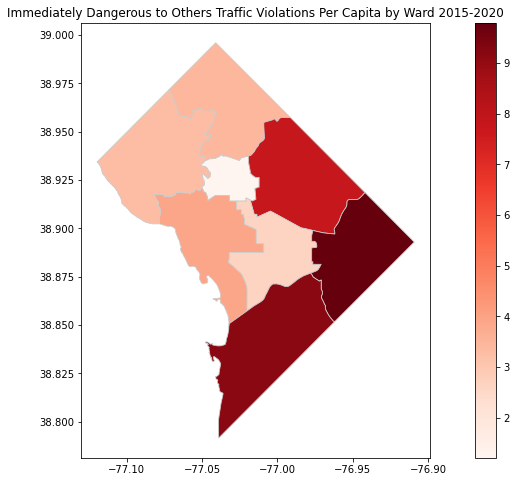

In [45]:
#Map per capita incidence of "Immediately Dangerous to Others" violations
variable = "Immediately Dangerous to Others"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
map_df.plot(column=variable, cmap="Reds", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Immediately Dangerous to Others Traffic Violations Per Capita by Ward 2015-2020')
plt.show()

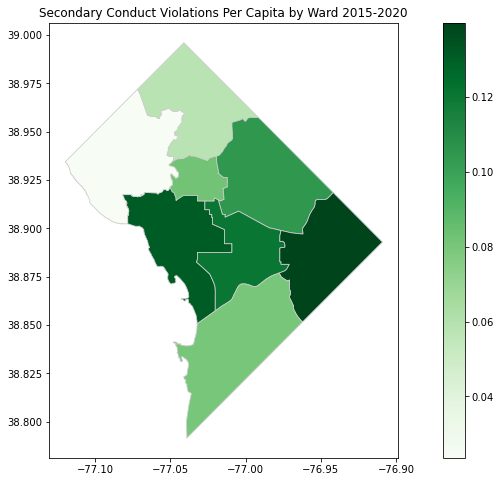

In [44]:
#Map per capita incidence of ""Secondary Conduct Violations" violations
variable = "Secondary Conduct Violations"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Secondary Conduct Violations Per Capita by Ward 2015-2020')
plt.show()

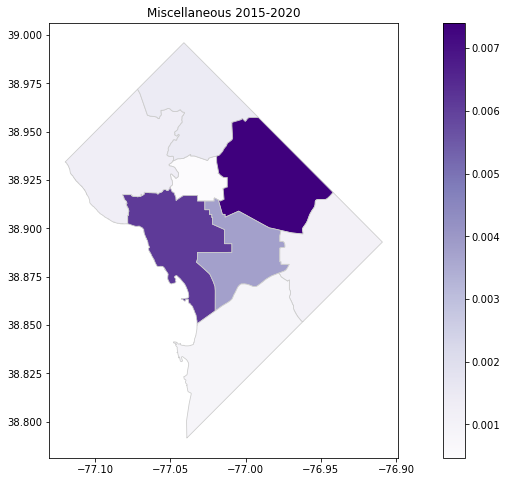

In [43]:
#Map per capita incidence of "Miscellaneous" violations
variable = "Miscellaneous"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
map_df.plot(column=variable, cmap="Purples", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Miscellaneous 2015-2020')
plt.show()

## Word Vectorizer Code - Ignore

In [ ]:
Speeding=['MPH','SPEEDING','SPEED']
Traffic=['STOP','DISTRACTED','ATTENTION','TURN','LEFT','RIGHT','LANES','STREET','YIELD','TRAFFIC','PASS','DRIVE','DRIVING','INTERSECTION','PEDESTRIAN','CYCLIST','BICYCLE']
Permit=['REGISTRATION','REGISTERED','UNREGISTERED','INSURANCE','PERMIT','TAGS']
Car=['WINDOW','WINDOWS','LIGHT','LIGHTS','PLATE','BUMPER','BUMPERS','PLATES']

In [ ]:
k=df_violations.Violations
p=[i.lower() for i in k[0:600000]]

In [ ]:
Violations=pd.DataFrame(df_violations.Violations.unique(),columns=['Violations'])

In [ ]:
Violations.dropna(axis=0)

In [ ]:
#Word Preprocessing
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')

#Make a dataframe of unique column names
Violations=pd.DataFrame(df_violations.Violations.unique(),columns=['Violations'])
#Remove 'None' Entry
Violations.dropna(axis=0,inplace=True)
#Replace any non letters with a white space (the carrot makes it 'replace everything except')
Violations['Violations_Edit']= Violations['Violations'].str.replace('[^a-zA-Z]', ' ')
#Make all text lower case
Violations['Violations_Edit'] = Violations['Violations_Edit'].str.lower()

In [ ]:
Violations

In [ ]:
#Correct Misspellings
Violations['Violations_Edit'].loc[1]='owner operate or permit operation of uninsured vehicle'
Violations['Violations_Edit'].loc[176]='less than yrs old mandatory seat belt violation'
Violations['Violations_Edit'].loc[214]='less than yrs old passenger restraint violation'
Violations['Violations_Edit'].loc[114]='bike pmd fail to yield right of way to pedestrian or vehicle'
Violations['Violations_Edit'].loc[254]='failure yield row transit bus'

#Lemmatize Entires, Remove Stop Words
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

def lemmatize_remove_stopwords(text):
    y=[lemmatizer.lemmatize(w) for w in word_tokenize(text)]
    h=[c for c in y if c not in stopwords.words('english')]
    return " ".join(h)

Violations['Violations_Edit']=Violations['Violations_Edit'].apply(lemmatize_remove_stopwords)
Violations

In [ ]:
Violations.to_csv('Violations_Unique.csv')

In [ ]:
h=Violations['Violations_Edit'].tolist()
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(h)
pd.set_option('display.max_rows', None)
df_vw=pd.DataFrame(X_train_counts.toarray(),columns=count_vect.get_feature_names())
df_vw.T

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=5)
model.fit(X_train_counts)
components_df = pd.DataFrame(model.components_, columns=df_vw.columns)
for i in range(0,5):
    component = components_df.iloc[i]
    print('Component ',i)
    print(component.nlargest())

In [ ]:
transformed_data=model.transform(X_train_counts)
df_=pd.DataFrame(transformed_data,index=Violations.Violations)
#df_.columns=['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']
df_.columns=['Zero','One','Two','Three','Four']
df_['MajorComponent']=df_.idxmax(axis=1).values
df_.sort_values('MajorComponent')
category_map={'Zero':'Dangerous to Others','One':'Conduct Violations','Two':'Dangerous to Others','Three':'Dangerous to Others','Four':'Conduct Violations',}
df_['New_Map']=df_['MajorComponent'].map(category_map)
df_.reset_index(inplace=True)

In [ ]:
from sklearn.preprocessing import normalize
norm_features = normalize(transformed_data)
df = pd.DataFrame(norm_features,index=Violations.Violations)
article = df.iloc[81]
# Compute the dot products: similarities
similarities = df.dot(article)
print(similarities.nlargest())

In [ ]:
#Code for generating categories via input
#dict_={}
#for i in list(df_['Violations']):
#    txt=input(i+' ')
#    dict_[i]=txt
#dict_['OPERATE A VEHICLE IN VIOLATION OF A RESTRICTION']=C
#dict_['SPEEDING IN CMV UP TO 10 MPH OVER SPEED LIMIT C']=D
#dict_['FAIL TO TURN WHEEL TO CURB']=D
#import json
#with open("Categories.json", "w") as outfile:  
#    json.dump(dict_, outfile) 